## Análisis de la Expansión del COVID-19 en la Ciudad de Buenos Aires
<br> 

### Universidad Tecnológica Nacional - Reg. Buenos Aires
<br>

### Ingeniería Industrial - Ciencia de Datos (clusterAI)
#### Noviembre, 2020
<br>
<br>

#### Autores:
<br>

##### Demaestri, Juan Ignacio
##### Gutiérrez, Manuel

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
geopandas_is_installed = False
isFirst =True
#install geopandas
if (geopandas_is_installed == True) :
    import geopandas as gps

In [3]:

#Sklearn Tools
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA, KernelPCA
from sklearn import decomposition
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier


## Datasets

In [4]:
covid_df = pd.read_csv('datasets\\01_casos_covid19.csv')
#Extracted from: https://datos.gob.ar/dataset/salud-covid-19-casos-registrados-republica-argentina
#Last Update: 04/nov/2020


c:\devapps\python38\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (10,11,13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
covid_df.shape

(680052, 14)

In [6]:
barrios_caba_densidad  = pd.read_csv('datasets\\03_ba_censo_2010.csv')

In [7]:
barrios_caba_densidad.shape

(48, 7)

In [8]:
clima_caba_df  = pd.read_csv('datasets\\05_MetereologiaCABA.csv')

In [9]:
subte_caba_df  = pd.read_csv('datasets\\06_Subtes2020.csv', delimiter=",")

## EDA - Exploratory Data Analysis

###  (01) COVID Dataset

In [10]:
# String to Datetime
covid_df.fecha_clasificacion = pd.to_datetime(covid_df.fecha_clasificacion,format='%d%b%Y:%H:%M:%S.%f')
covid_df.fecha_toma_muestra  = pd.to_datetime(covid_df.fecha_toma_muestra,format='%d%b%Y:%H:%M:%S.%f')
covid_df.fecha_alta          = pd.to_datetime(covid_df.fecha_alta,format='%d%b%Y:%H:%M:%S.%f')

In [11]:
#feature extraction - less important features
covid_df = covid_df.iloc[:,[2,3,4,5,6,7,8,9,11,12]]

In [12]:
#dataset filtration - Buenos Aires City
covid_caba_df = covid_df[(covid_df.provincia == 'CABA') & (covid_df.clasificacion == 'confirmado')]

In [13]:
covid_caba_df.shape

(143876, 10)

In [14]:
covid_caba_df.head(5)

,fecha_toma_muestra,fecha_clasificacion,provincia,barrio,comuna,genero,edad,clasificacion,fallecido,fecha_alta
1,2020-08-20,2020-08-21,CABA,VILLA CRESPO,15.0,femenino,51.0,confirmado,NaN,NaT
2,2020-08-10,2020-08-10,CABA,COLEGIALES,13.0,masculino,59.0,confirmado,NaN,NaT
3,2020-08-18,2020-08-18,CABA,BARRACAS,4.0,femenino,41.0,confirmado,NaN,NaT
6,2020-08-18,2020-08-21,CABA,PALERMO,14.0,femenino,35.0,confirmado,NaN,NaT
7,2020-08-19,2020-08-20,CABA,MONSERRAT,1.0,masculino,50.0,confirmado,NaN,NaT


### (03) Dataset CABA densidad

In [15]:
group_covidBybarrio_df = covid_caba_df.groupby(["barrio"])["barrio"].count().reset_index(name='casos')
group_covidBybarrio_df = group_covidBybarrio_df.sort_values(by="casos", ascending=False)

In [16]:
barrios_covid_densidad = barrios_caba_densidad.merge(group_covidBybarrio_df, left_on='barrio', right_on='barrio')


In [17]:
barrios_covid_densidad['densidad_covid'] = (barrios_covid_densidad.casos / barrios_covid_densidad.superficie)

In [18]:
barrios_covid_densidad = barrios_covid_densidad.sort_values(by=['densidad_covid'], ascending=False)

In [19]:
filter_covid_densidad = barrios_covid_densidad.iloc[:,[1,6,8]]

In [20]:
barrios_caba_densidad = barrios_caba_densidad.sort_values(by=['densidad_pobacional'], ascending=False)

### (05) Dataset Clima CABA

In [21]:
# Convierto tipo de dato string a datetime
clima_caba_df.Fecha = pd.to_datetime(clima_caba_df.Fecha,format='%d/%m/%Y')

## Dataset Subte

In [22]:
subte_caba_df.tail(5)

#format mm/dd/YYYY

,FECHA,DESDE,HASTA,LINEA,MOLINETE,ESTACION,pax_pagos,pax_pases_pagos,pax_franq,pax_TOTAL
4589766,9/30/2020,23:00:00,23:15:00,LineaA,LineaA_SanPedrito_Este_Turn01,San Pedrito,0.0,0.0,1.0,1.0
4589767,9/30/2020,23:00:00,23:15:00,LineaD,LineaD_Palermo_Turn06,Palermo,0.0,0.0,1.0,1.0
4589768,9/30/2020,23:15:00,23:30:00,LineaD,LineaD_Bulnes_N_Turn01,Bulnes,0.0,0.0,2.0,2.0
4589769,9/30/2020,23:15:00,23:30:00,LineaE,LineaE_RetiroE_S_Turn01,Retiro E,0.0,0.0,1.0,1.0
4589770,9/30/2020,23:30:00,23:45:00,LineaD,LineaD_Pueyrredon_Turn02,Pueyrredon.D,0.0,0.0,1.0,1.0


In [23]:
subte_caba_df["FECHA"] = pd.to_datetime(subte_caba_df["FECHA"], dayfirst=False )
subte_caba_df = subte_caba_df[["FECHA", "pax_TOTAL"]].groupby("FECHA").sum()

In [24]:
subte_caba_df["FECHA"]=subte_caba_df.index
subte_caba_df.info()



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 260 entries, 2020-01-01 to 2020-12-02
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   pax_TOTAL  260 non-null    float64       
 1   FECHA      260 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.1 KB


In [25]:
subte_caba_df["FECHA"] = pd.to_datetime(subte_caba_df["FECHA"], dayfirst=False )


### Pre Proccesing

In [26]:
covid_caba_clean = covid_caba_df[['fecha_toma_muestra', 'barrio', 'genero', 'edad', 'clasificacion']]
covid_caba_clean = covid_caba_clean.merge(barrios_caba_densidad, on="barrio", how="inner")
covid_caba_clean.head(3)
covid_caba_clean.shape


(140172, 11)

In [27]:
covid_caba_clean = covid_caba_clean.merge(clima_caba_df, left_on="fecha_toma_muestra", right_on="Fecha", how="inner")
covid_caba_clean.info()

covid_caba_clean.clasificacion.unique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139865 entries, 0 to 139864
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   fecha_toma_muestra   139865 non-null  datetime64[ns]
 1   barrio               139865 non-null  object        
 2   genero               139865 non-null  object        
 3   edad                 139830 non-null  float64       
 4   clasificacion        139865 non-null  object        
 5   comuna               139865 non-null  object        
 6   habitantes           139865 non-null  int64         
 7   mujer                139865 non-null  int64         
 8   varon                139865 non-null  int64         
 9   superficie           139865 non-null  float64       
 10  densidad_pobacional  139865 non-null  float64       
 11  Fecha                139865 non-null  datetime64[ns]
 12  tMax                 139865 non-null  float64       
 13  tMin          

array(['confirmado'], dtype=object)

In [28]:
#BORRO la parte subtes
covid_caba_clean = covid_caba_clean.merge(subte_caba_df, left_on="fecha_toma_muestra", right_on=subte_caba_df["FECHA"], how="inner")
covid_caba_clean.head(5)


,fecha_toma_muestra,barrio,genero,edad,clasificacion,comuna,habitantes,mujer,varon,superficie,...,tMin,tProm,Humedad,vVel,vDir,pMax,pMin,pProm,pax_TOTAL,FECHA
0,2020-08-20,VILLA CRESPO,femenino,51.0,confirmado,Comuna 15,81959,44757,37202,3.61,...,0.8,7.3,58,35,Calma,1028.2,1031.8,1030.0,69640.0,2020-08-20
1,2020-08-20,VILLA CRESPO,femenino,46.0,confirmado,Comuna 15,81959,44757,37202,3.61,...,0.8,7.3,58,35,Calma,1028.2,1031.8,1030.0,69640.0,2020-08-20
2,2020-08-20,VILLA CRESPO,masculino,36.0,confirmado,Comuna 15,81959,44757,37202,3.61,...,0.8,7.3,58,35,Calma,1028.2,1031.8,1030.0,69640.0,2020-08-20
3,2020-08-20,VILLA CRESPO,femenino,31.0,confirmado,Comuna 15,81959,44757,37202,3.61,...,0.8,7.3,58,35,Calma,1028.2,1031.8,1030.0,69640.0,2020-08-20
4,2020-08-20,VILLA CRESPO,femenino,39.0,confirmado,Comuna 15,81959,44757,37202,3.61,...,0.8,7.3,58,35,Calma,1028.2,1031.8,1030.0,69640.0,2020-08-20


In [29]:
covid_caba_clean = covid_caba_clean.sort_values(by="fecha_toma_muestra", ascending=True)
covid_caba_clean.shape

(126985, 23)

In [30]:
caba_genero_dummie = pd.get_dummies(covid_caba_clean.genero)
caba_clasificacion_dummie = pd.get_dummies(covid_caba_clean.clasificacion)


In [31]:
covid_caba_clean

,fecha_toma_muestra,barrio,genero,edad,clasificacion,comuna,habitantes,mujer,varon,superficie,...,tMin,tProm,Humedad,vVel,vDir,pMax,pMin,pProm,pax_TOTAL,FECHA
126936,2020-02-16,VILLA URQUIZA,femenino,33.0,confirmado,Comuna 12,91563,49384,42179,5.45,...,23.3,28.45,73,57,Calma,1002.5,1007.5,1005.00,207806.0,2020-02-16
126984,2020-03-01,PUERTO MADERO,masculino,43.0,confirmado,Comuna 1,6726,3115,3611,5.03,...,21.1,27.35,67,21,Calma,1016.5,1019.5,1018.00,1186969.0,2020-03-01
126983,2020-03-03,SAN CRISTOBAL,masculino,47.0,confirmado,Comuna 3,48611,26283,22328,2.04,...,22.5,27.15,70,30,Norte,1013.4,1017.0,1015.20,1118806.0,2020-03-03
126982,2020-03-04,VILLA DEL PARQUE,masculino,68.0,confirmado,Comuna 11,55273,30213,25060,3.40,...,21.0,26.60,70,20,Calma,1014.4,1016.7,1015.55,1135479.0,2020-03-04
126980,2020-03-05,BOEDO,masculino,45.0,confirmado,Comuna 5,47306,25371,21935,2.61,...,21.6,25.60,70,24,Norte,1015.1,1018.9,1017.00,1164013.0,2020-03-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73119,2020-10-02,RECOLETA,masculino,55.0,confirmado,Comuna 2,157932,89890,68042,6.29,...,7.5,11.95,66,44,Este,1014.1,1028.9,1021.50,1035204.0,2020-10-02
73120,2020-10-02,RECOLETA,masculino,23.0,confirmado,Comuna 2,157932,89890,68042,6.29,...,7.5,11.95,66,44,Este,1014.1,1028.9,1021.50,1035204.0,2020-10-02
73121,2020-10-02,RECOLETA,masculino,64.0,confirmado,Comuna 2,157932,89890,68042,6.29,...,7.5,11.95,66,44,Este,1014.1,1028.9,1021.50,1035204.0,2020-10-02
73110,2020-10-02,FLORES,masculino,60.0,confirmado,Comuna 7,164310,87984,76326,8.59,...,7.5,11.95,66,44,Este,1014.1,1028.9,1021.50,1035204.0,2020-10-02


In [32]:
covid_caba_casos = covid_caba_df.groupby(["fecha_toma_muestra"])['clasificacion'].count().reset_index(name='clasificacion')


In [33]:
covid_caba_casos.head(4)

,fecha_toma_muestra,clasificacion
0,2019-07-20,1
1,2019-07-30,1
2,2019-08-28,1
3,2020-02-06,1


In [34]:
covid_caba_casos["Casos Día Anterior"]=covid_caba_casos.clasificacion.shift(1)
covid_caba_casos

,fecha_toma_muestra,clasificacion,Casos Día Anterior
0,2019-07-20,1,NaN
1,2019-07-30,1,1.0
2,2019-08-28,1,1.0
3,2020-02-06,1,1.0
4,2020-02-16,1,1.0
...,...,...,...
236,2020-10-20,619,612.0
237,2020-10-21,491,619.0
238,2020-10-22,365,491.0
239,2020-10-23,158,365.0


In [35]:
covid_caba_clean.columns

Index(['fecha_toma_muestra', 'barrio', 'genero', 'edad', 'clasificacion',
       'comuna', 'habitantes', 'mujer', 'varon', 'superficie',
       'densidad_pobacional', 'Fecha', 'tMax', 'tMin', 'tProm', 'Humedad',
       'vVel', 'vDir', 'pMax', 'pMin', 'pProm', 'pax_TOTAL', 'FECHA'],
      dtype='object')

In [36]:
caba_regression_covid = covid_caba_clean[['fecha_toma_muestra', 'Fecha', 'tMax', 'tMin', 'Humedad',
       'vVel', "vDir", 'pProm', 'pax_TOTAL']]
caba_regression_covid

,fecha_toma_muestra,Fecha,tMax,tMin,Humedad,vVel,vDir,pProm,pax_TOTAL
126936,2020-02-16,2020-02-16,33.6,23.3,73,57,Calma,1005.00,207806.0
126984,2020-03-01,2020-03-01,33.6,21.1,67,21,Calma,1018.00,1186969.0
126983,2020-03-03,2020-03-03,31.8,22.5,70,30,Norte,1015.20,1118806.0
126982,2020-03-04,2020-03-04,32.2,21.0,70,20,Calma,1015.55,1135479.0
126980,2020-03-05,2020-03-05,29.6,21.6,70,24,Norte,1017.00,1164013.0
...,...,...,...,...,...,...,...,...,...
73119,2020-10-02,2020-10-02,16.4,7.5,66,44,Este,1021.50,1035204.0
73120,2020-10-02,2020-10-02,16.4,7.5,66,44,Este,1021.50,1035204.0
73121,2020-10-02,2020-10-02,16.4,7.5,66,44,Este,1021.50,1035204.0
73110,2020-10-02,2020-10-02,16.4,7.5,66,44,Este,1021.50,1035204.0


#### Feature Engineering

In [37]:
caba_wind_dummie = pd.get_dummies(caba_regression_covid.vDir)
caba_wind_dummie

,Calma,Este,Noreste,Norte,Oeste,Sudeste,Sudoeste,Sur
126936,1,0,0,0,0,0,0,0
126984,1,0,0,0,0,0,0,0
126983,0,0,0,1,0,0,0,0
126982,1,0,0,0,0,0,0,0
126980,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...
73119,0,1,0,0,0,0,0,0
73120,0,1,0,0,0,0,0,0
73121,0,1,0,0,0,0,0,0
73110,0,1,0,0,0,0,0,0


In [38]:
caba_regression_covid = caba_regression_covid.join([caba_wind_dummie])
#caba_regression_covid.head(5)
covid_caba_casos

,fecha_toma_muestra,clasificacion,Casos Día Anterior
0,2019-07-20,1,NaN
1,2019-07-30,1,1.0
2,2019-08-28,1,1.0
3,2020-02-06,1,1.0
4,2020-02-16,1,1.0
...,...,...,...
236,2020-10-20,619,612.0
237,2020-10-21,491,619.0
238,2020-10-22,365,491.0
239,2020-10-23,158,365.0


In [39]:
caba_regression_covid

,fecha_toma_muestra,Fecha,tMax,tMin,Humedad,vVel,vDir,pProm,pax_TOTAL,Calma,Este,Noreste,Norte,Oeste,Sudeste,Sudoeste,Sur
126936,2020-02-16,2020-02-16,33.6,23.3,73,57,Calma,1005.00,207806.0,1,0,0,0,0,0,0,0
126984,2020-03-01,2020-03-01,33.6,21.1,67,21,Calma,1018.00,1186969.0,1,0,0,0,0,0,0,0
126983,2020-03-03,2020-03-03,31.8,22.5,70,30,Norte,1015.20,1118806.0,0,0,0,1,0,0,0,0
126982,2020-03-04,2020-03-04,32.2,21.0,70,20,Calma,1015.55,1135479.0,1,0,0,0,0,0,0,0
126980,2020-03-05,2020-03-05,29.6,21.6,70,24,Norte,1017.00,1164013.0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73119,2020-10-02,2020-10-02,16.4,7.5,66,44,Este,1021.50,1035204.0,0,1,0,0,0,0,0,0
73120,2020-10-02,2020-10-02,16.4,7.5,66,44,Este,1021.50,1035204.0,0,1,0,0,0,0,0,0
73121,2020-10-02,2020-10-02,16.4,7.5,66,44,Este,1021.50,1035204.0,0,1,0,0,0,0,0,0
73110,2020-10-02,2020-10-02,16.4,7.5,66,44,Este,1021.50,1035204.0,0,1,0,0,0,0,0,0


In [40]:
covid_caba_casos

,fecha_toma_muestra,clasificacion,Casos Día Anterior
0,2019-07-20,1,NaN
1,2019-07-30,1,1.0
2,2019-08-28,1,1.0
3,2020-02-06,1,1.0
4,2020-02-16,1,1.0
...,...,...,...
236,2020-10-20,619,612.0
237,2020-10-21,491,619.0
238,2020-10-22,365,491.0
239,2020-10-23,158,365.0


In [41]:
caba_regression_covid = caba_regression_covid.merge(covid_caba_casos, 
                                                    left_on="fecha_toma_muestra", 
                                                    right_on="fecha_toma_muestra", 
                                                    how="inner")
caba_regression_covid

,fecha_toma_muestra,Fecha,tMax,tMin,Humedad,vVel,vDir,pProm,pax_TOTAL,Calma,Este,Noreste,Norte,Oeste,Sudeste,Sudoeste,Sur,clasificacion,Casos Día Anterior
0,2020-02-16,2020-02-16,33.6,23.3,73,57,Calma,1005.00,207806.0,1,0,0,0,0,0,0,0,1,1.0
1,2020-03-01,2020-03-01,33.6,21.1,67,21,Calma,1018.00,1186969.0,1,0,0,0,0,0,0,0,1,1.0
2,2020-03-03,2020-03-03,31.8,22.5,70,30,Norte,1015.20,1118806.0,0,0,0,1,0,0,0,0,1,1.0
3,2020-03-04,2020-03-04,32.2,21.0,70,20,Calma,1015.55,1135479.0,1,0,0,0,0,0,0,0,1,1.0
4,2020-03-05,2020-03-05,29.6,21.6,70,24,Norte,1017.00,1164013.0,0,0,0,1,0,0,0,0,4,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126980,2020-10-02,2020-10-02,16.4,7.5,66,44,Este,1021.50,1035204.0,0,1,0,0,0,0,0,0,903,871.0
126981,2020-10-02,2020-10-02,16.4,7.5,66,44,Este,1021.50,1035204.0,0,1,0,0,0,0,0,0,903,871.0
126982,2020-10-02,2020-10-02,16.4,7.5,66,44,Este,1021.50,1035204.0,0,1,0,0,0,0,0,0,903,871.0
126983,2020-10-02,2020-10-02,16.4,7.5,66,44,Este,1021.50,1035204.0,0,1,0,0,0,0,0,0,903,871.0


In [42]:
covid_caba_casos.duplicated().any()

False

#### Final Dataset

In [43]:
caba_regression_final = caba_regression_covid[['fecha_toma_muestra',  'tMax', 'tMin', 'Humedad', 'vVel',
       'pProm', 'Calma', 'Este', 'Noreste', 'Norte',
       'Oeste', 'Sudeste', 'Sudoeste', 'Sur', 'pax_TOTAL',
       'Casos Día Anterior', 'clasificacion']] 

In [44]:

caba_regression_final = caba_regression_final.drop_duplicates(subset=["fecha_toma_muestra"], keep="first")


In [45]:
caba_regression_final = caba_regression_final.sort_values(by="fecha_toma_muestra", ascending=True) 

In [46]:
#caba_regression_final = caba_regression_final[(caba_regression_final.fecha_toma_muestra < '2020-10-03')]
caba_regression_final.dropna(inplace=True)

In [47]:
caba_regression_final['Casos Día Anterior']=caba_regression_final['Casos Día Anterior'].astype('int64')
caba_regression_final['tMin']=caba_regression_final['tMin'].astype('int64')
caba_regression_final['pProm']=caba_regression_final['pProm'].astype('int64')
caba_regression_final

,fecha_toma_muestra,tMax,tMin,Humedad,vVel,pProm,Calma,Este,Noreste,Norte,Oeste,Sudeste,Sudoeste,Sur,pax_TOTAL,Casos Día Anterior,clasificacion
0,2020-02-16,33.6,23,73,57,1005,1,0,0,0,0,0,0,0,207806.0,1,1
1,2020-03-01,33.6,21,67,21,1018,1,0,0,0,0,0,0,0,1186969.0,1,1
2,2020-03-03,31.8,22,70,30,1015,0,0,0,1,0,0,0,0,1118806.0,1,1
3,2020-03-04,32.2,21,70,20,1015,1,0,0,0,0,0,0,0,1135479.0,1,1
4,2020-03-05,29.6,21,70,24,1017,0,0,0,1,0,0,0,0,1164013.0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122515,2020-09-28,23.6,7,59,36,1010,0,0,0,0,0,0,1,0,84759.0,638,935
123428,2020-09-29,24.4,13,64,36,1008,0,0,0,1,0,0,0,0,92183.0,935,958
124343,2020-09-30,27.6,14,70,27,1004,0,0,0,1,0,0,0,0,91911.0,958,955
125266,2020-10-01,22.4,13,55,31,1009,0,0,0,0,0,0,0,1,991589.0,955,871


### Regression Model

In [48]:
#y = np.array(caba_regression_final[["clasificacion"]])
y = caba_regression_final[["clasificacion"]]
y.shape


(215, 1)

In [49]:
caba_regression_final.columns

Index(['fecha_toma_muestra', 'tMax', 'tMin', 'Humedad', 'vVel', 'pProm',
       'Calma', 'Este', 'Noreste', 'Norte', 'Oeste', 'Sudeste', 'Sudoeste',
       'Sur', 'pax_TOTAL', 'Casos Día Anterior', 'clasificacion'],
      dtype='object')

In [50]:
x = caba_regression_final[['tMax', 'tMin', 'Humedad', 'vVel', 'pProm',
       'pax_TOTAL', 'Calma', 'Este', 'Noreste', 'Norte', 'Oeste', 'Sudeste',
       'Sudoeste', 'Sur', 'Casos Día Anterior', "pax_TOTAL"]]
                           

In [51]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.20, random_state=42)
#x_poly_train, x_poly_test = train_test_split(x, test_size=0.25, random_state=42)


In [52]:
xtrain.shape

(172, 16)

In [53]:
scaler = preprocessing.StandardScaler().fit(xtrain)
scaler

StandardScaler()

In [54]:
xtrain_scal = scaler.transform(xtrain)


In [55]:
xtest_scal = scaler.transform(xtest)


In [56]:
# Aqui estamos agregando las features polinomicas LUEGO de escalar los datos
#grad_poly = 14
#x_train_poly_scaled = PolynomialFeatures(grad_poly).fit_transform(xtrain_scal)
#x_test_poly_scaled = PolynomialFeatures(grad_poly).fit_transform(xtest_scal)

In [57]:
results = pd.DataFrame(columns=['Model','R2','MSE','MAE'])


In [58]:
lr = LinearRegression()

In [59]:
lr.fit(xtrain_scal, ytrain)

LinearRegression()

In [60]:
ypred = lr.predict(xtest_scal)

In [61]:
ytest.shape

(43, 1)

In [62]:
# calculo el error de mi modelo con las muestras de train = error de train
np.sqrt(mean_squared_error(ytest, ypred))

177.53311253020138

In [63]:
mean_squared_error(ytest, ypred)

31518.00604466115

In [64]:
mean_absolute_error(ytest, ypred)

116.950733428867

In [65]:
results = results.append({'Model':'Linear Regression',
                                'R2':np.sqrt(mean_squared_error(ytest, ypred)),
                                'MSE':mean_squared_error(ytest, ypred),
                                'MAE':mean_absolute_error(ytest, ypred)},ignore_index=True)

##### Support Vector Regression

In [66]:
n_folds = 8 
est = SVR(max_iter=20000)
# Lista del parametro lambda (parametro 'alpha')
parameters = {'C' : [0.1, 1, 10, 50, 100, 500, 2000,50000],
              'gamma':[0.01, 0.05,0.1,0.5,1,10],
            "kernel":["rbf", "gauss"]}

gs = GridSearchCV(est, param_grid=parameters,refit=True,
                  cv=n_folds, scoring="neg_mean_squared_error",
                  verbose=5, n_jobs=5)

In [67]:
gs.fit(xtrain_scal, ytrain)


Fitting 8 folds for each of 96 candidates, totalling 768 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 202 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 768 out of 768 | elapsed:    2.3s finished
c:\devapps\python38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GridSearchCV(cv=8, estimator=SVR(max_iter=20000), n_jobs=5,
             param_grid={'C': [0.1, 1, 10, 50, 100, 500, 2000, 50000],
                         'gamma': [0.01, 0.05, 0.1, 0.5, 1, 10],
                         'kernel': ['rbf', 'gauss']},
             scoring='neg_mean_squared_error', verbose=5)

In [68]:
print(gs.best_estimator_, "\n")
print(gs.best_params_, "\n")
print(gs.best_score_, "\n")

SVR(C=2000, gamma=0.01, max_iter=20000) 

{'C': 2000, 'gamma': 0.01, 'kernel': 'rbf'} 

-23133.863860289246 



In [69]:
svr_prediction = gs.best_estimator_.predict(xtest_scal)
svr_r2 = r2_score(y_true=ytest, y_pred=svr_prediction)
svr_mse = mean_squared_error(y_true=ytest, y_pred=svr_prediction)
svr_mae = mean_absolute_error(y_true=ytest, y_pred=svr_prediction)

R2 score: 0.829941
MSE: 39583.940697
MAE: 129.987108


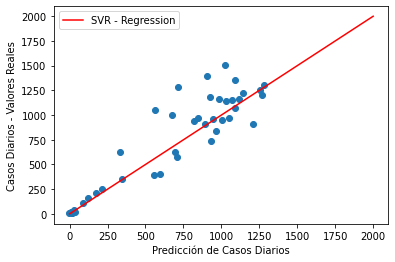

In [70]:
plt.scatter(svr_prediction, ytest)
plt.plot(np.arange(0,2000),np.arange(0,2000), 'r', label='SVR - Regression')
plt.xlabel('Predicción de Casos Diarios')
plt.ylabel('Casos Diarios - Valores Reales')
plt.legend()
print(f'R2 score: {svr_r2:.6f}')
print(f'MSE: {svr_mse:.6f}')
print(f'MAE: {svr_mae:.6f}')

In [71]:
results = results.append({'Model':'SVR',
                                'R2':svr_r2,
                                'MSE':svr_mse,
                                'MAE':svr_mae},ignore_index=True)

##### KNN Regression

In [72]:
n_folds = 10
knn = KNeighborsRegressor()
k_params = np.arange(0,100,2)
knn_params = [{'n_neighbors': k_params}]

gs = GridSearchCV(knn, param_grid=knn_params,refit=True,
                  cv=n_folds, scoring="neg_mean_squared_error",
                  verbose=5, n_jobs=5)

In [73]:
gs.fit(xtrain_scal, ytrain)


Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 477 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 500 out of 500 | elapsed:    0.4s finished


GridSearchCV(cv=10, estimator=KNeighborsRegressor(), n_jobs=5,
             param_grid=[{'n_neighbors': array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98])}],
             scoring='neg_mean_squared_error', verbose=5)

In [74]:
print(gs.best_estimator_, "\n")
print(gs.best_params_, "\n")
print(gs.best_score_, "\n")

KNeighborsRegressor(n_neighbors=8) 

{'n_neighbors': 8} 

-65605.0458129085 



In [75]:
knn_prediction = gs.best_estimator_.predict(xtest_scal)
knn_r2 = r2_score(y_true=ytest, y_pred=knn_prediction)
knn_mse = mean_squared_error(y_true=ytest, y_pred=knn_prediction)
knn_mae = mean_absolute_error(y_true=ytest, y_pred=knn_prediction)

R2 score: 0.698580
MAE: 207.215116
MSE: 70160.481831


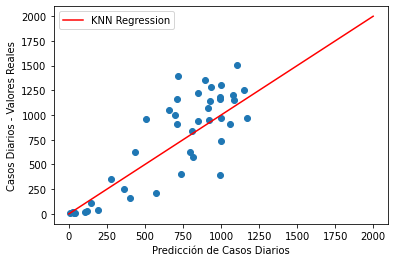

In [76]:
plt.scatter(knn_prediction, ytest)
plt.plot(np.arange(0,2000),np.arange(0,2000), 'r', label='KNN Regression')
plt.xlabel('Predicción de Casos Diarios')
plt.ylabel('Casos Diarios - Valores Reales')
plt.legend()
print(f'R2 score: {knn_r2:.6f}')
print(f'MAE: {knn_mae:.6f}')
print(f'MSE: {knn_mse:.6f}')

In [77]:
results = results.append({'Model':'KNN',
                                'R2':knn_r2,
                                'MSE':knn_mse,
                                'MAE':knn_mae},ignore_index=True)


##### Random Forest

In [78]:
n_estimators=np.arange(10, 300, 10)
n_folds=5
rf = make_regression()

params_rf = {"n_estimators": n_estimators}
regr = RandomForestRegressor(max_depth=2, random_state=0)
gs = GridSearchCV(regr, param_grid=params_rf,refit=True,
                  cv=n_folds, scoring="neg_mean_squared_error",
                  verbose=5, n_jobs=5)

In [79]:
gs.fit(xtrain_scal, ytrain)


Fitting 5 folds for each of 29 candidates, totalling 145 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 145 out of 145 | elapsed:    4.8s finished
c:\devapps\python38\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, estimator=RandomForestRegressor(max_depth=2, random_state=0),
             n_jobs=5,
             param_grid={'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260,
       270, 280, 290])},
             scoring='neg_mean_squared_error', verbose=5)

In [80]:
print(gs.best_estimator_, "\n")
print(gs.best_params_, "\n")
print(gs.best_score_, "\n")


RandomForestRegressor(max_depth=2, n_estimators=190, random_state=0) 

{'n_estimators': 190} 

-23934.065369146814 



In [81]:
rf_prediction = gs.best_estimator_.predict(xtest_scal)
rf_r2 = r2_score(y_true=ytest, y_pred=rf_prediction)
rf_mse = mean_squared_error(y_true=ytest, y_pred=rf_prediction)
rf_mae = mean_absolute_error(y_true=ytest, y_pred=rf_prediction)

R2 score: 0.884
MAE: 116.550
MSE: 27000.682


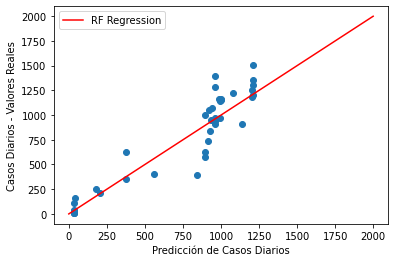

In [82]:
plt.scatter(rf_prediction, ytest)
plt.plot(np.arange(0,2000),np.arange(0,2000), 'r', label='RF Regression')
plt.xlabel('Predicción de Casos Diarios')
plt.ylabel('Casos Diarios - Valores Reales')
plt.legend()
print(f'R2 score: {rf_r2:.3f}')
print(f'MAE: {rf_mae:.3f}')
print(f'MSE: {rf_mse:.3f}')

In [83]:

results = results.append({'Model':'Random Forest',
                                'R2':rf_r2,
                                'MSE':rf_mse,
                                'MAE':rf_mae},ignore_index=True)

In [84]:
pd.set_option('display.float_format', lambda x: '%.3f' % x) # Para acotar los decimales en pandas
display(results)

,Model,R2,MSE,MAE
0,Linear Regression,177.533,31518.006,116.951
1,SVR,0.830,39583.941,129.987
2,KNN,0.699,70160.482,207.215
3,Random Forest,0.884,27000.682,116.550


### Regression Model 

#### without considering cases from the day before

In [85]:
caba_regression_final_2 = caba_regression_covid[['fecha_toma_muestra',  'tMax', 'tMin', 'Humedad', 'vVel',
       'pProm', 'Calma', 'Este', 'Noreste', 'Norte',
       'Oeste', 'Sudeste', 'Sudoeste', 'Sur', 'pax_TOTAL',
       'clasificacion']] 

In [86]:
caba_regression_final_2 = caba_regression_final_2.drop_duplicates(subset=["fecha_toma_muestra"], keep="first")
caba_regression_final_2

,fecha_toma_muestra,tMax,tMin,Humedad,vVel,pProm,Calma,Este,Noreste,Norte,Oeste,Sudeste,Sudoeste,Sur,pax_TOTAL,clasificacion
0,2020-02-16,33.600,23.300,73,57,1005.000,1,0,0,0,0,0,0,0,207806.000,1
1,2020-03-01,33.600,21.100,67,21,1018.000,1,0,0,0,0,0,0,0,1186969.000,1
2,2020-03-03,31.800,22.500,70,30,1015.200,0,0,0,1,0,0,0,0,1118806.000,1
3,2020-03-04,32.200,21.000,70,20,1015.550,1,0,0,0,0,0,0,0,1135479.000,1
4,2020-03-05,29.600,21.600,70,24,1017.000,0,0,0,1,0,0,0,0,1164013.000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122515,2020-09-28,23.600,7.300,59,36,1010.300,0,0,0,0,0,0,1,0,84759.000,935
123428,2020-09-29,24.400,13.900,64,36,1008.850,0,0,0,1,0,0,0,0,92183.000,958
124343,2020-09-30,27.600,14.900,70,27,1004.850,0,0,0,1,0,0,0,0,91911.000,955
125266,2020-10-01,22.400,13.400,55,31,1009.300,0,0,0,0,0,0,0,1,991589.000,871


In [87]:
y2 = caba_regression_final_2[["clasificacion"]]


In [88]:
caba_regression_final_2.columns

Index(['fecha_toma_muestra', 'tMax', 'tMin', 'Humedad', 'vVel', 'pProm',
       'Calma', 'Este', 'Noreste', 'Norte', 'Oeste', 'Sudeste', 'Sudoeste',
       'Sur', 'pax_TOTAL', 'clasificacion'],
      dtype='object')

In [89]:
x2 = caba_regression_final_2[['tMax', 'tMin', 'Humedad', 'vVel', 'pProm',
       'pax_TOTAL', 'Calma', 'Este', 'Noreste', 'Norte', 'Oeste', 'Sudeste',
       'Sudoeste', 'Sur', "pax_TOTAL"]]

In [90]:
xtrain2, xtest2, ytrain2, ytest2 = train_test_split(x2, y2, test_size=0.20, random_state=42)


In [91]:
scaler = preprocessing.StandardScaler().fit(xtrain2)
scaler

StandardScaler()

In [92]:
xtrain2_scal = scaler.transform(xtrain2)


In [93]:
xtest2_scal = scaler.transform(xtest2)


In [94]:
results2 = pd.DataFrame(columns=['Model','R2','MSE','MAE'])


In [95]:
lr = LinearRegression()

In [96]:
lr.fit(xtrain2_scal, ytrain2)

LinearRegression()

In [97]:
ypred2 = lr.predict(xtest2_scal)

In [98]:
np.sqrt(mean_squared_error(ytest2, ypred2))

400.7890539311179

In [99]:
mean_squared_error(ytest2, ypred2)

160631.86575100053

##### Support Vector Regression 
##### without considering cases from the day before

In [100]:
n_folds = 8
est = SVR(max_iter=20000)
# Lista del parametro lambda (parametro 'alpha')
parameters = {'C' : [0.1, 1, 10, 50, 100, 500, 2000,50000],
              'gamma':[0.01, 0.05,0.1,0.5,1,10],
            "kernel":["rbf", "gauss"]}

gs2 = GridSearchCV(est, param_grid=parameters,refit=True,
                  cv=n_folds, scoring="neg_mean_squared_error",
                  verbose=5, n_jobs=5)

In [101]:
gs2.fit(xtrain2_scal, ytrain2)


Fitting 8 folds for each of 96 candidates, totalling 768 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 544 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 768 out of 768 | elapsed:    0.4s finished
c:\devapps\python38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GridSearchCV(cv=8, estimator=SVR(max_iter=20000), n_jobs=5,
             param_grid={'C': [0.1, 1, 10, 50, 100, 500, 2000, 50000],
                         'gamma': [0.01, 0.05, 0.1, 0.5, 1, 10],
                         'kernel': ['rbf', 'gauss']},
             scoring='neg_mean_squared_error', verbose=5)

In [102]:
print(gs2.best_estimator_, "\n")
print(gs2.best_params_, "\n")
print(gs2.best_score_, "\n")

SVR(C=2000, gamma=0.01, max_iter=20000) 

{'C': 2000, 'gamma': 0.01, 'kernel': 'rbf'} 

-164521.4922478879 



In [103]:
svr2_prediction = gs2.best_estimator_.predict(xtest2_scal)
svr2_r2 = r2_score(y_true=ytest2, y_pred=svr2_prediction)
svr2_mse = mean_squared_error(y_true=ytest2, y_pred=svr2_prediction)
svr2_mae = mean_absolute_error(y_true=ytest2, y_pred=svr2_prediction)

R2 score: 0.221004
MSE: 181323.888332
MAE: 347.479334


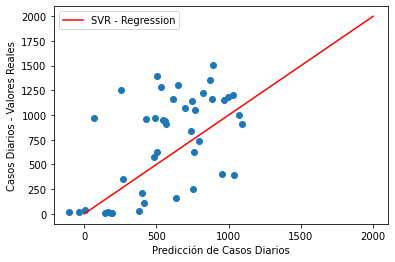

In [104]:
plt.scatter(svr2_prediction, ytest2)
plt.plot(np.arange(0,2000),np.arange(0,2000), 'r', label='SVR - Regression')
plt.xlabel('Predicción de Casos Diarios')
plt.ylabel('Casos Diarios - Valores Reales')
plt.legend()
print(f'R2 score: {svr2_r2:.6f}')
print(f'MSE: {svr2_mse:.6f}')
print(f'MAE: {svr2_mae:.6f}')